# Basic MCMC
Part of the Bayesian neural networks via MCMC: a Python-based tutorial

This section of the tutorial covers the development of a basic MCMC algorithm.

### Imports

In [1]:
%pdb 1
%load_ext autoreload
%autoreload 2

Automatic pdb calling has been turned ON


In [2]:
import numpy as np
from scipy.stats import binom, uniform
# visulisation function
from functions.visualisations import histogram_trace

## Define the functions required for MCMC sampling

- Prior distribution
    - A uniform distribution 
- Likelihood function
    - A binomial distribtuion 
- Acceptance ratio
    - Implementation of a Metropolis-Hasting criterion

In [28]:
# Define Prior Function - Uniform Distribution    
def prior(p):
    '''
    Input: 
        - p: 
    Output:
        - 
    '''
    return uniform.pdf(p)

# Define the Likelihood P(x|p) - binomial distribution
def likelihood(p):
    '''
    Input:
        - p:
    Output:
        - 
    '''
    # Define shape parameters for the binomial dsitribution
    x = 50
    n = 100
    # XX @Sahani - can be update this so this is a difference between two similar distributions so that it gives a better analogy of predicted vs actual?
    return binom.pmf(x, n, p)
    
# This function will accept the current and proposed values 
def acceptance_ratio(p, p_new):
    '''
    Input:
        - p:
        - p_new:
    Output:
        - R: Acceptance ratio
    '''
    # Return R, using the functions we created before
    return min(1, ((likelihood(p_new) / likelihood(p)) * (prior(p_new) / prior(p))))

## Sample using MCMC

- Create the MCMC loop and sample the posterior distribution

In [29]:
## MCMC Settings and Setup
n_samples = 5000 # number of samples to draw from the posterior
burn_in = 500 # number of samples to discard before recording draws from the posterior

results = [] # Create an empty list to store samples
p = np.random.uniform(0, 1) # Initialise a value of p
count = 0 # count the number of accepted samples

In [30]:
# Create the MCMC sampling loop
verbose = False
for ii in np.arange(n_samples):
    # Propose a new value of p randomly from the proposal distribution 
    # in this case a uniform distribution between 0 and 1
    p_new = np.random.uniform(0, 1)
    if verbose:
        # print the new value of p
        print('Sample {}: {:.3f}'.format(ii, p_new))
    # Compute acceptance probability
    alpha = acceptance_ratio(p, p_new)
    # Draw random sample (uniform between 0 and 1) to compare with alpha
    u = np.random.uniform(0, 1)
    # If alpha is greater than u, accept the new value of p (set p = p_new)
    if u < alpha:
        p = p_new # update p
        count = count +1 # add to the count of accepted samples
    # Record values after burn in 
    if ii > burn_in:
        results.append(p)

## Analyse the results
Plot the posterior distribution and trace

In [31]:
# print(results, 'results')
per_accept = (count/n_samples)*100
print('{:.3f} % accepted'.format(per_accept))
posterior_mean = np.mean(results)
print('{:.3f} mean value of posterior'.format(posterior_mean))

15.660 % accepted
0.496 mean value of posterior


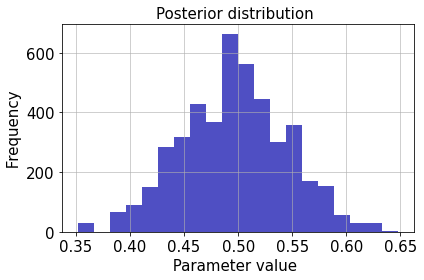

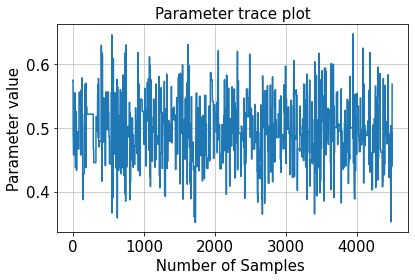

In [32]:
histogram_trace(results)